# Import the relevant libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2
import PIL

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Import the dataset

In [ ]:
from pathlib import Path
import imghdr
import subprocess

data_dir = "images/datasets/3"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions
print(subprocess.run(['pwd']))

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            try:
                subprocess.run(["mv", f"/notebooks/{filepath}", "/notebooks/uploads/problematic"])
            except FileNotFoundError:
                print("File is not found: ", filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            try:
                subprocess.run(["mv", f"/notebooks/{filepath}", "/notebooks/uploads/problematic"])
            except FileNotFoundError:
                print("File is not found: ", filepath)

In [2]:
DIR = "images/datasets/3/"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, 
                                                                    subset="training", seed=42, 
                                                                    batch_size=128, smart_resize=True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                  subset="validation", seed=42,
                                                                  batch_size=128, smart_resize=True)

Found 22280 files belonging to 2 classes.
Using 20052 files for training.
Found 22280 files belonging to 2 classes.
Using 2228 files for validation.


### Optimise the training and testing performance

In [3]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['biodegradable', 'non-biodegradable']


### Performing Data Augmentation

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Rescaling(1./255)
])

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Rescaling(1./255)
])

In [5]:
train_dataset_augmented = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [6]:
# preprocess image
def preprocess_image(image):
    return tf.keras.applications.resnet.preprocess_input(image)

train_dataset_preprocessed = train_dataset_augmented.map(lambda x, y: (preprocess_image(x), y))

### Show First Batch Of Images

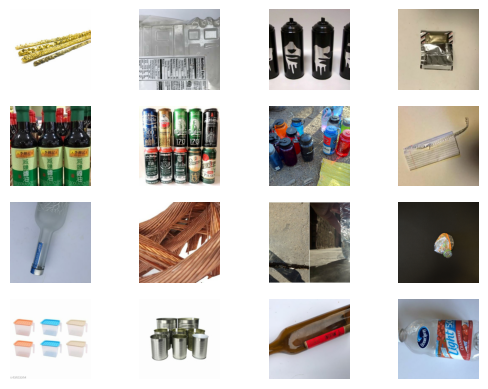

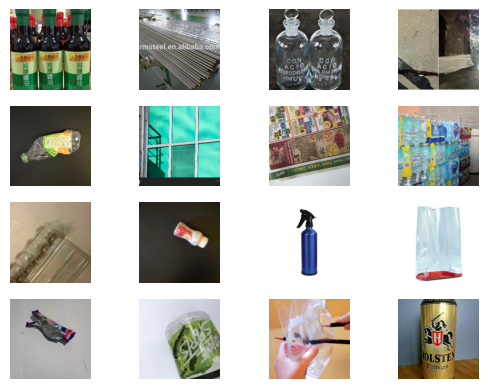

In [23]:
show_dataset_original = train_dataset.take(1)
dataset_original_augmented = show_dataset_original.map(lambda x, y: (data_augmentation(x), y))
# print(list(train_dataset.take(1))[0])
# print(list(train_dataset.take(1)))
# print(len(list(show_dataset)))
plt.figure()
for i, tensor in enumerate(list(show_dataset_original)[0][0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(tf.keras.utils.array_to_img(tensor))
    plt.axis("off")

plt.figure()
for i, tensor in enumerate(list(dataset_original_augmented)[0][0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(tf.keras.utils.array_to_img(tensor))
    plt.axis("off")

# MODELS

### Resnet152 Model 

In [9]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False
    
# last_output = baseModel.layers[-1].output
# # x = tf.keras.layers.Dropout(0.5)(last_output)
# x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

last_output = baseModel.output
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(last_output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
history = model.fit(train_dataset_preprocessed, validation_data=test_dataset, epochs=epochs)

Epoch 1/50
157/157 [==============================] - 159s 958ms/step - loss: 0.6615 - accuracy: 0.6132 - val_loss: 1.4903 - val_accuracy: 0.5983
Epoch 2/50
157/157 [==============================] - 152s 952ms/step - loss: 0.6363 - accuracy: 0.6477 - val_loss: 2.1601 - val_accuracy: 0.6041
Epoch 3/50
157/157 [==============================] - 152s 950ms/step - loss: 0.6222 - accuracy: 0.6640 - val_loss: 2.2527 - val_accuracy: 0.6122
Epoch 4/50
157/157 [==============================] - 151s 942ms/step - loss: 0.6168 - accuracy: 0.6709 - val_loss: 2.3620 - val_accuracy: 0.6194
Epoch 5/50
157/157 [==============================] - 150s 940ms/step - loss: 0.6108 - accuracy: 0.6757 - val_loss: 2.2616 - val_accuracy: 0.6333
Epoch 6/50
157/157 [==============================] - 152s 952ms/step - loss: 0.6072 - accuracy: 0.6784 - val_loss: 2.6153 - val_accuracy: 0.6266
Epoch 7/50
157/157 [==============================] - 149s 934ms/step - loss: 0.6041 - accuracy: 0.6807 - val_loss: 2.6452 -

### Resnet50 Model

In [ ]:
baseModel = tf.keras.applications.ResNet50(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=1)

for layers in baseModel.layers:
    layers.trainable=False
    
# last_output = baseModel.layers[-1].output
# # x = tf.keras.layers.Dropout(0.5)(last_output)
# x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

last_output = baseModel.output
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(last_output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
history = model.fit(train_dataset_preprocessed, validation_data=test_dataset, epochs=epochs)

### Model Evaluation

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

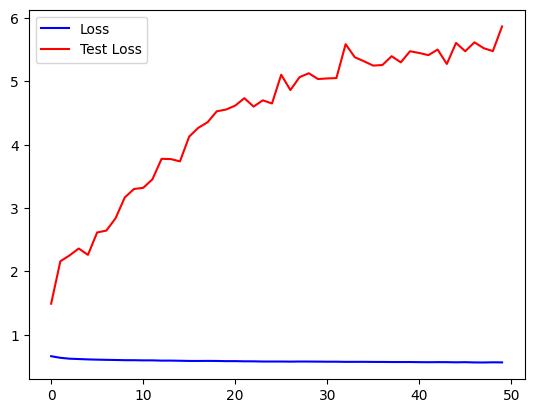

In [10]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.save("train loss vs test loss.png")
plt.show()

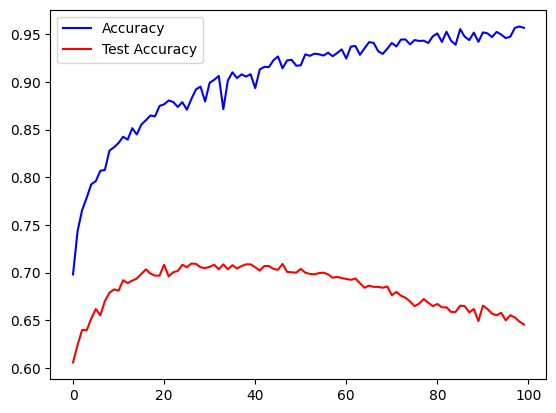

In [ ]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.save("accuracy vs val accuracy.png")
plt.show()

Text(0, 0.5, 'Loss')

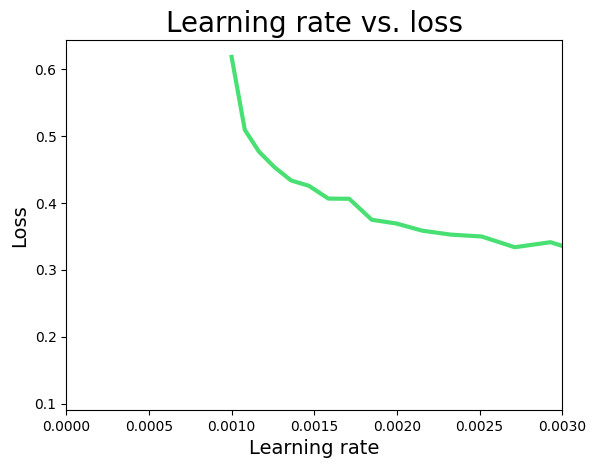

In [ ]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)
plt.save("Learning rate vs. loss.png")

# Save Model

In [ ]:
import datetime
import pytz
date_string = datetime.datetime.now(pytz.timezone('Asia/Manila'))
formatted_date_string = date_string.strftime("%m%d%y-%H%MH")
model.save(f'model_{formatted_date_string}.keras')

: 

# Testing

1/1 [==============================] - 2s 2s/step
[[0.72730374 0.27269626]]
[72.73038  27.269627] 
 ['biodegradable', 'non-biodegradable']
Prediction:  biodegradable 72.73037433624268%


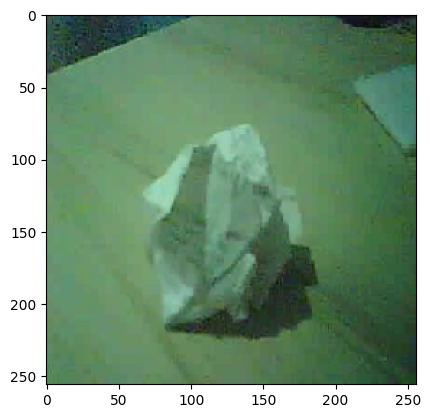

In [10]:
# url = "https://images.unsplash.com/photo-1577705998148-6da4f3963bc8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Nnx8Y2FyZGJvYXJkfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"
# image = tf.keras.utils.get_file("images/paper.jpeg", origin=url)
path = "/notebooks/images/tests/random/file.jpg"
img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
#score = tf.nn.softmax(predictions[0])

plt.imshow(img)
# print(predictions)
# print("Prediction: " + str(classes[np.argmax(predictions)]))
print(predictions)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

In [3]:
# Tensor Preprocessing
path = "/notebooks/images/tests/random/file.jpg"
img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array_expanded = tf.expand_dims(img_array, 0)
preprocessed_image = tf.keras.applications.resnet.preprocess_input(img_array_expanded)
print(preprocessed_image[0])

tf.Tensor(
[[[-11.939003 -17.779    -37.68    ]
  [-25.939003 -31.779    -53.68    ]
  [-16.939003 -20.779    -47.68    ]
  ...
  [-69.939    -81.779    -92.68    ]
  [-68.939    -79.779    -92.68    ]
  [-65.939    -76.779    -89.68    ]]

 [[-14.939003 -20.779    -40.68    ]
  [-26.939003 -31.779    -55.68    ]
  [-17.939003 -21.779    -48.68    ]
  ...
  [-71.939    -82.779    -95.68    ]
  [-69.939    -80.779    -93.68    ]
  [-67.939    -77.779    -93.68    ]]

 [[-19.939003 -25.779    -47.68    ]
  [-27.939003 -32.779    -56.68    ]
  [-20.939003 -24.779    -51.68    ]
  ...
  [-67.939    -80.779    -93.68    ]
  [-66.939    -78.779    -94.68    ]
  [-63.939003 -75.779    -92.68    ]]

 ...

 [[-15.939003  20.221    -36.68    ]
  [-15.939003  20.221    -36.68    ]
  [-15.939003  20.221    -36.68    ]
  ...
  [-64.939    -51.779    -94.68    ]
  [-64.939    -51.779    -94.68    ]
  [-64.939    -51.779    -94.68    ]]

 [[-15.939003  20.221    -36.68    ]
  [-15.939003  20.221    -

In [ ]:
# images_ds = tf.keras.utils.image_dataset_from_directory(
#     'images',
#     labels='inferred',
#     label_mode='int',
#     batch_size=None
# )

# def add_batch_dimension(image):
#   # Expand the dimension at index 0 (beginning)
#   return tf.expand_dims(image, axis=0)

# print(images.class_names)
# images_ds = images_ds.map(add_batch_dimension)
# predictions = model.predict(images_ds)
# print(predictions)

In [ ]:
# images = tf.keras.utils.image_dataset_from_directory(
#     'images',
#     labels='inferred',
#     label_mode='int',
#     batch_size=None
# )
# print(images.class_names)
# for element in images:
#     print(element)
#     img_array = tf.expand_dims(element, 0)

#     predictions = model.predict(img_array)
#     #score = tf.nn.softmax(predictions[0])

#     plt.imshow(img)
#     # print(predictions)
#     # print("Prediction: " + str(classes[np.argmax(predictions)]))
#     print(predictions[0]*100, "\n", classes)
#     print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

Found 5 files belonging to 1 classes.


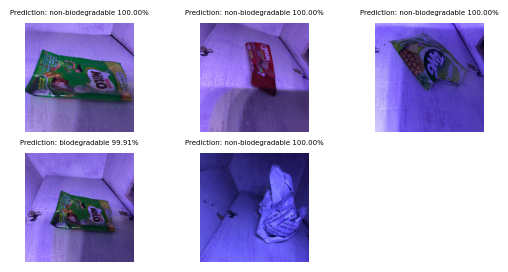

In [11]:
image_ds = tf.keras.utils.image_dataset_from_directory(
    '/notebooks/images/tests/random/eval',
    labels=None,
    batch_size=None
)
# classes = train_dataset.class_names
# expand dimention at the front (axis=0)
image_ds_expanded = image_ds.map(lambda image: tf.expand_dims(image, axis=0))

# predict using model

plt.figure()
for i, img in enumerate(image_ds_expanded):
    prediction = model(img)[0]
    # print(prediction[0]*100, "\n", classes)
    # print("Prediction: ", classes[np.argmax(prediction)], f"{prediction[np.argmax(prediction)]*100}%")
    pil_img = tf.keras.preprocessing.image.array_to_img(tf.reshape(img[0], (256, 256, 3)))
    plt.subplot(3, 3, i + 1)
    plt.imshow(pil_img)
    title = f"Prediction: {classes[np.argmax(prediction)]} {prediction[np.argmax(prediction)]*100:.2f}%"
    plt.title(title, fontsize=5)
    plt.axis("off")

Found 63 files belonging to 1 classes.
TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


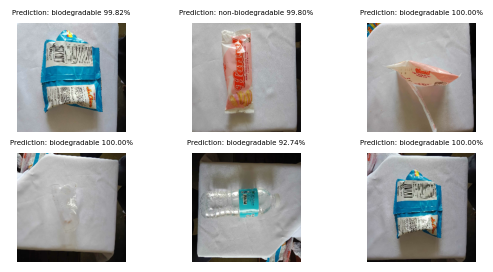

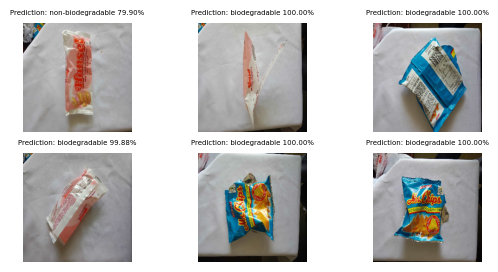

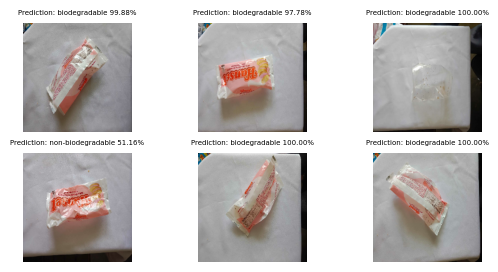

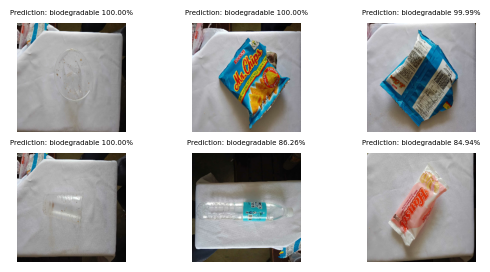

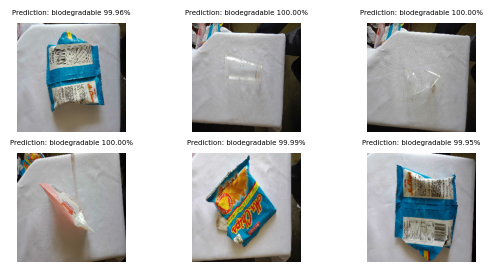

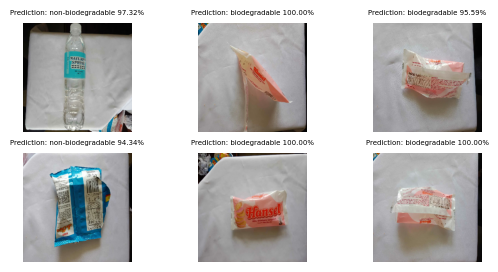

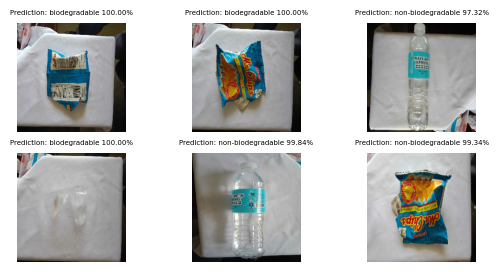

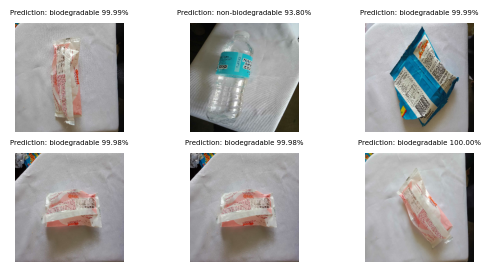

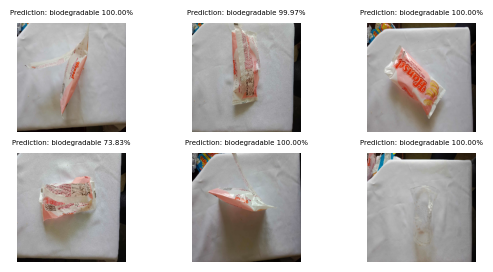

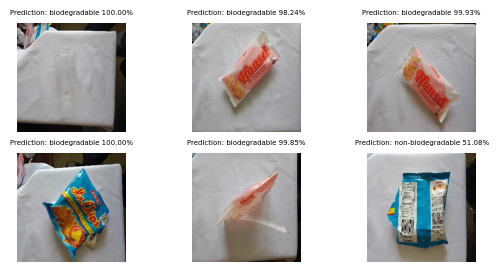

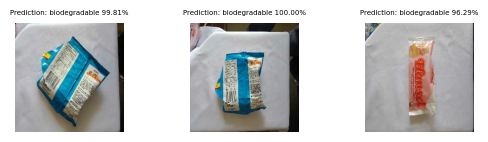

In [8]:
# exhaustive (more efficient)
BATCH_SIZE = 6
image_ds = tf.keras.utils.image_dataset_from_directory(
    '/notebooks/images/tests/test_1',
    labels=None,
    batch_size=BATCH_SIZE
)
# classes = train_dataset.class_names
# expand dimention at the front (axis=0)
print(image_ds.element_spec)
print(image_ds)

for batch in image_ds:
    predictions = model.predict_on_batch(batch)
    plt.figure()
    for i, pair in enumerate(zip(predictions, batch)):
        prediction, img = pair
        # print(prediction[0]*100, "\n", classes)
        # print("Prediction: ", classes[np.argmax(prediction)], f"{prediction[np.argmax(prediction)]*100}%")
        
        # pil_img = tf.keras.preprocessing.image.array_to_img(tf.reshape(img[0], (256, 256, 3)))
        pil_img = tf.keras.preprocessing.image.array_to_img(img)
        plt.subplot(3, 3, i + 1)
        plt.imshow(pil_img)
        title = f"Prediction: {classes[np.argmax(prediction)]} {prediction[np.argmax(prediction)]*100:.2f}%"
        plt.title(title, fontsize=5)
        plt.axis("off")

Found 63 files belonging to 1 classes.
<MapDataset element_spec=TensorSpec(shape=(1, 256, 256, 3), dtype=tf.float32, name=None)>


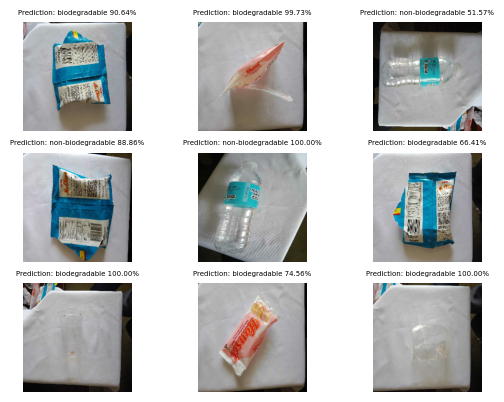

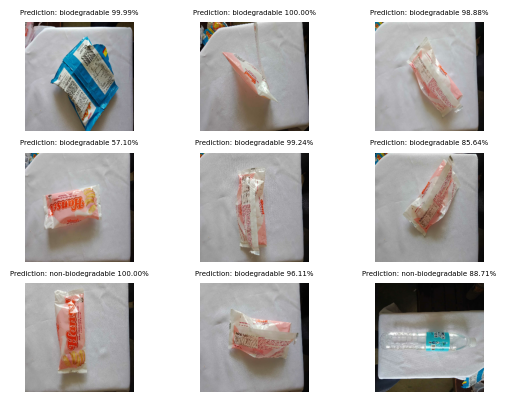

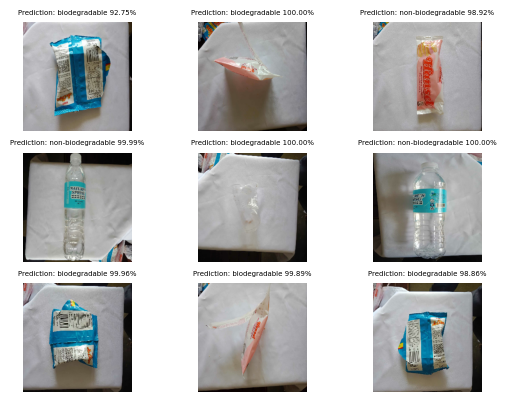

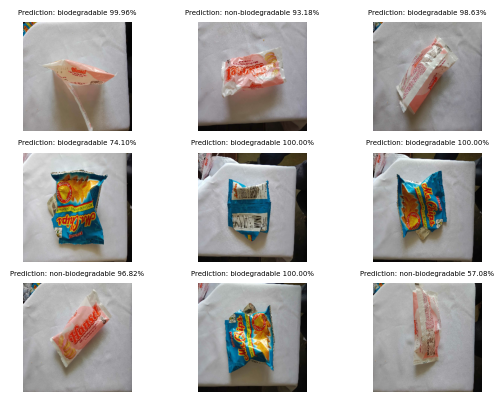

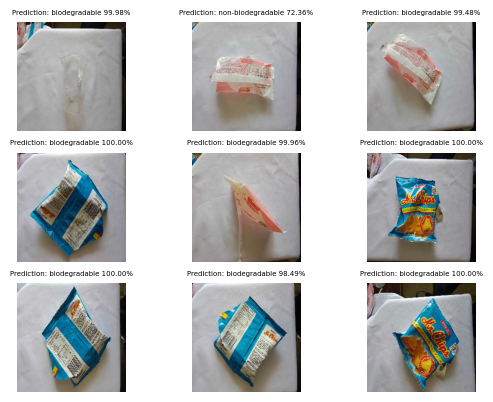

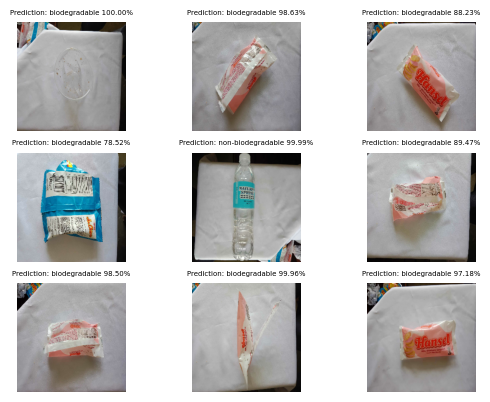

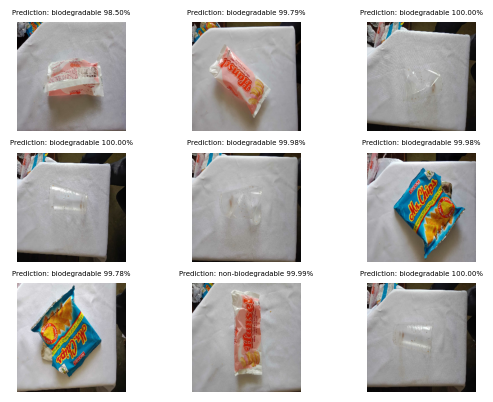

In [8]:
# exhaustive prediction

image_ds = tf.keras.utils.image_dataset_from_directory(
    '/notebooks/images/tests/test_1',
    labels=None,
    batch_size=None
)
# classes = train_dataset.class_names
# expand dimention at the front (axis=0)
image_ds_expanded = image_ds.map(lambda image: tf.expand_dims(image, axis=0))
print(image_ds_expanded)

# batch dataset
image_ds_expanded_and_batched = image_ds_expanded.batch(9)

for batch in image_ds_expanded_and_batched:
    plt.figure()
    for i, img in enumerate(batch):
        prediction = model(img)[0]
        # print(prediction[0]*100, "\n", classes)
        # print("Prediction: ", classes[np.argmax(prediction)], f"{prediction[np.argmax(prediction)]*100}%")

        pil_img = tf.keras.preprocessing.image.array_to_img(tf.reshape(img[0], (256, 256, 3)))
        plt.subplot(3, 3, i + 1)
        plt.imshow(pil_img)
        title = f"Prediction: {classes[np.argmax(prediction)]} {prediction[np.argmax(prediction)]*100:.2f}%"
        plt.title(title, fontsize=5)
        plt.axis("off")